### Notebook to accompany "A guide to LIGO-Virgo detector noise"

This notebook is intended to reproduce some plots from the paper "A guide to LIGO-Virgo detector noise and extratraction of transient gravitational-wave signals" (arXiv:1908.11170)

This notebook is intended as an educational demonstration to reproduce some of the figures in the paper ["A guide to LIGO-Virgo detector noise and extraction of transient gravitational-wave signals"](https://inspirehep.net/record/1751757) , and may differ from the [C library code](https://doi.org/10.5281/zenodo.3380539) that has been used to produce the figures of the paper. 
Additional open source software libraries used by the LIGO Scientific Collaboration and Virgo Collaboration to produce published results are also available. 
See, for example, the list of open source libraries at https://www.gw-openscience.org/software/

#### Python Environment

Make sure to select the kernel to be the IGWN conda environment created in the `environment_setup.ipynb`.

In VSCode select: *Select Kernel* > *Select Another Kernel...* > *Python Environments...* > *igwn-[version]*

#### Download data files

Download each of the following files into the directory where you would like to run the notebook. 
Most of these data files are described at:

https://www.gw-openscience.org/events/GW150914/

In [1]:
# -- Helper python module to open LIGO data files
! wget -q -N https://www.gw-openscience.org/static/sample_code/readligo.py 

In [2]:
# -- Download 4096 second data files around GW150914
! wget -q -N https://www.gw-openscience.org/GW150914data/L-L1_LOSC_4_V2-1126257414-4096.hdf5
! wget -q -N https://www.gw-openscience.org/GW150914data/H-H1_LOSC_4_V2-1126257414-4096.hdf5

In [3]:
# -- Download 32 second data files around GW150914
! wget -q -N https://www.gw-openscience.org/GW150914data/H-H1_LOSC_4_V2-1126259446-32.hdf5
! wget -q -N https://www.gw-openscience.org/GW150914data/L-L1_LOSC_4_V2-1126259446-32.hdf5

In [4]:
# -- Download waveform template
! wget -q -N https://www.gw-openscience.org/GW150914data/P150914/fig2-unfiltered-waveform-H.txt

In [5]:
# -- Download data from Figure 1 of GW150914 detection paper
! wget -q -N https://www.gw-openscience.org/GW150914data/P150914/fig1-observed-H.txt
! wget -q -N https://www.gw-openscience.org/GW150914data/P150914/fig1-residual-H.txt
! wget -q -N https://www.gw-openscience.org/GW150914data/P150914/fig1-observed-L.txt
! wget -q -N https://www.gw-openscience.org/GW150914data/P150914/fig1-residual-L.txt

#### Import needed python modules

Most of these are common python packages, and all should be in the IGWN environment.

In [6]:
# Standard python numerical analysis imports:
import numpy as np
import scipy
from scipy import signal
from scipy.interpolate import interp1d
from scipy.signal import butter, filtfilt
import h5py
import json

# plotting items
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

# -- Set some parameters that control how plots are displayed
plt.rcParams['figure.figsize'] = [5, 3]
plt.rcParams['lines.linewidth'] = .75

# LIGO-specific readligo.py 
# Download from https://www.gw-openscience.org/static/sample_code/readligo.py
import readligo as rl

We calculate the Power spectral density 

In [8]:
# these 4096 second files are useful for computing more accurate psds
large_data_filenames = {'GW150914': 'LOSC_4_V2-1126257414-4096.hdf5'}
fn_H1 = 'H-H1_' + large_data_filenames['GW150914']
fn_L1 = 'L-L1_' + large_data_filenames['GW150914']

# this is the approximate event time which is used in the papers
time_center = 1126259462

# get sample rate from the H1 data file
with h5py.File(fn_H1, 'r') as hdf_file:
    dt = hdf_file['strain/Strain'].attrs['Xspacing']
fs = int(1.0/dt)
print("Using sample rate of {0} Hz found in file: {1}".format(fs, fn_H1))

Using sample rate of 4096 Hz found in file: H-H1_LOSC_4_V2-1126257414-4096.hdf5


We define some functions for use later

In [22]:


def get_full_psds(dir,eventnames, large_data_filenames,
                  make_plots=False, plot_others=False):
    """Obtains full 1024 second psds for all the events specified. Uses the Welch
    average technique, along with other less accurate techniques if
    specified. Can also plot the psd obtained.
    
    Args: 
        eventnames (list): list of events to get psds for
        large_datafilenames (dict): dictionary whose keys are the eventnames 
            and whose values are the filenames of the large amounts of strain
            data used, without the added 'H-<det>_'
        make_plots (bool, optional): if set to True, plot psd data
        plot_others (bool, optional): if set to True, also obtain psd data 
            without averaging as well as with no window
    
    Returns:
        dict: A dictionary containing psds for each detector for each event 
            specified in eventnames.
    """

    large_data_psds = {}
    for eventname in eventnames:
        large_data_psds[eventname] = {'H1': [], 'L1': []}

        # get filename
        fn_H1 = 'H-H1_' + large_data_filenames[eventname]
        fn_L1 = 'L-L1_' + large_data_filenames[eventname]

        # get strain data
        strain_H1, time_H1, chan_dict_H1 = rl.loaddata(fn_H1, 'H1')
        strain_L1, time_L1, chan_dict_L1 = rl.loaddata(fn_L1, 'L1')

        # both H1 and L1 will have the same time vector, so:
        time = time_H1

        indxt_around = np.where((time >= time_center - 512) & (
            time < time_center + 512))

        # number of sample for the fast fourier transform:
        NFFT = int( 4 * fs )           # Use 4 seconds of data for each fourier transform
        NOVL = int( 1 * NFFT / 2 )     # The number of points of overlap between segments used in Welch averaging
        psd_window = scipy.signal.tukey(NFFT, alpha=1./4)

        Pxx_H1, freqs = mlab.psd(strain_H1[indxt_around], Fs=fs, NFFT=NFFT,
                                 window=psd_window, noverlap=NOVL)
        Pxx_L1, freqs= mlab.psd(strain_L1[indxt_around], Fs=fs, NFFT=NFFT, 
                                window=psd_window, noverlap=NOVL)
        

        if (plot_others):
            # smaller window if we're not doing Welch's method
            short_indxt_away = np.where((time >= time_center - 2) & (
                time < time_center + 2))
            # psd using a tukey window but no welch averaging
            tukey_Pxx_H1, tukey_freqs = mlab.psd(
                strain_H1[short_indxt_away], Fs=fs, NFFT=NFFT, window=psd_window)
            # psd with no window, no averaging
            nowin_Pxx_H1, nowin_freqs = mlab.psd(
                strain_H1[short_indxt_away], Fs=fs, NFFT=NFFT, 
                window=mlab.window_none)

        # We will use interpolations of the PSDs computed above for whitening:
        psd_H1 = interp1d(freqs, Pxx_H1)
        psd_L1 = interp1d(freqs, Pxx_L1)

        large_data_psds[eventname]['H1'] = psd_H1
        large_data_psds[eventname]['L1'] = psd_L1

        if make_plots:
            fig = plt.figure(figsize=(8, 5))
            # scale x and y axes
            plt.xscale('log', base=2)
            plt.yscale('log', base=10)

            # plot nowindow, tukey, welch together 
            plt.plot(nowin_freqs, nowin_Pxx_H1,'purple',label= 'No Window',
                     alpha=.8, linewidth=.5)
            plt.plot(tukey_freqs, tukey_Pxx_H1 ,'green',label='Tukey Window',
                     alpha=.8, linewidth=.5)
            plt.plot(freqs, Pxx_H1,'black',label='Welch Average', alpha=.8,
                     linewidth=.5)

            # plot 1/f^2
            # give it the right starting scale to fit with the rest of the plots
            # don't include zero frequency
            inverse_square = np.array(list(map(lambda f: 1 / (f**2), 
                                    nowin_freqs[1:])))
            # inverse starts at 1 to take out 1/0
            scale_index = 500 # chosen by eye to fit the plot
            scale = nowin_Pxx_H1[scale_index]  / inverse_square[scale_index]
            plt.plot(nowin_freqs[1:], inverse_square * scale,'red',
                     label= r'$1 / f^2$', alpha=.8, linewidth=1)

            plt.axis([20, 512, 1e-48, 1e-41])
            plt.ylabel('Sn(t)')
            plt.xlabel('Freq (Hz)')
            plt.legend(loc='upper center')
            plt.title('LIGO PSD data near ' + eventname + ' at H1')
            plt.savefig(dir)
            plt.show()

    return large_data_psds

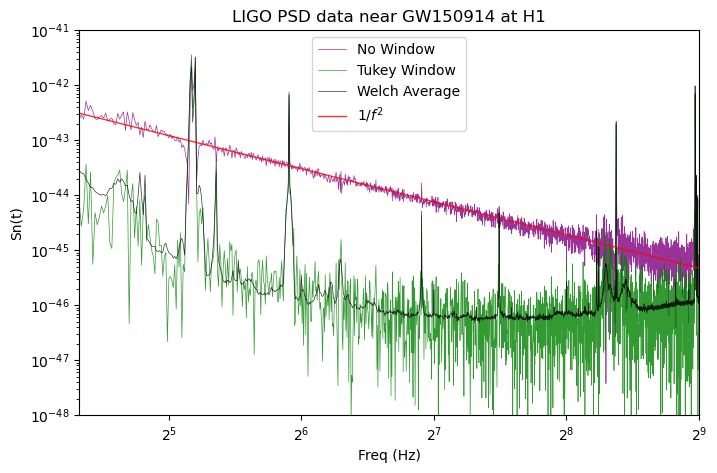

In [24]:
eventnames = ['GW150914']
large_data_psds = get_full_psds('../../figs/fig0.pdf', eventnames, large_data_filenames,
                                make_plots=True, plot_others=True)

We now write some Whitenoise and Bandpass functions to better see the signals

In [27]:
def whiten(strain, interp_psd, dt, phase_shift=0, time_shift=0):
    """Whitens strain data given the psd and sample rate, also applying a phase
    shift and time shift.

    Args:
        strain (ndarray): strain data
        interp_psd (interpolating function): function to take in freqs and output 
            the average power at that freq 
        dt (float): sample time interval of data
        phase_shift (float, optional): phase shift to apply to whitened data
        time_shift (float, optional): time shift to apply to whitened data (s)
    
    Returns:
        ndarray: array of whitened strain data
    """
    Nt = len(strain)
    # take the fourier transform of the data
    freqs = np.fft.rfftfreq(Nt, dt)

    # whitening: transform to freq domain, divide by square root of psd, then
    # transform back, taking care to get normalization right.
    hf = np.fft.rfft(strain)
    
    # apply time and phase shift
    hf = hf * np.exp(-1.j * 2 * np.pi * time_shift * freqs - 1.j * phase_shift)
    norm = 1./np.sqrt(1./(dt*2))
    white_hf = hf / np.sqrt(interp_psd(freqs)) * norm
    white_ht = np.fft.irfft(white_hf, n=Nt)
    return white_ht

def bandpass(strain, fband, fs):
    """Bandpasses strain data using a butterworth filter.
    
    Args:
        strain (ndarray): strain data to bandpass
        fband (ndarray): low and high-pass filter values to use
        fs (float): sample rate of data
    
    Returns:
        ndarray: array of bandpassed strain data
    """
    bb, ab = butter(4, [fband[0]*2./fs, fband[1]*2./fs], btype='band')
    normalization = np.sqrt((fband[1]-fband[0])/(fs/2))
    strain_bp = filtfilt(bb, ab, strain) / normalization
    return strain_bp



def plot_strain_data(dir, fn_H1, fn_L1, eventname):
    """Plots windowed, whitened, and bandpassed strain vs time near a given
    event.

    Args:
        fn_H1: name of H1 data file
        fn_L1: name of L1 data file
        eventname: name of the event
    """
    
    fband = [35.0, 350.0]

    strain_H1, time_H1, chan_dict_H1 = rl.loaddata(fn_H1, 'H1')
    strain_L1, time_L1, chan_dict_L1 = rl.loaddata(fn_L1, 'L1')

    # both H1 and L1 will have the same time vector
    time = time_H1
    
    # create our 4 second data window
    window_len = 4*fs
    dwindow = scipy.signal.tukey(window_len, alpha=1./4)

    # plot original strain data
    # only care about 4s around event
    plt.figure(figsize=(8, 8))
    plt.subplot(4, 1, 1)
    indxt = np.where((time >= time_center - 2) & (time < time_center + 2))
    plt.xlim([-2, 2])
    plt.plot(time[indxt] - time_center, strain_H1[indxt], 'blue', 
             label='Hanford Data', linewidth=.5)
    plt.legend()

    # plot windowed data
    plt.subplot(4, 1, 2)
    strain_windowed = dwindow * strain_H1[indxt]
    plt.xlim([-2, 2])
    plt.plot(time[indxt] - time_center, strain_windowed, 'green', 
             label='Windowed Data', linewidth=.5)
    plt.legend()
    
    
    # plot whitened data
    plt.subplot(4, 1, 3)
    strain_whitened = whiten(strain_windowed, 
                             large_data_psds[eventname]['H1'], dt)
    plt.plot(time[indxt] - time_center, strain_whitened, 'red', 
             label='Whitened Data', linewidth=.5)
    plt.legend()

    # plot bandpassed data
    plt.subplot(4, 1, 4)
    strain_bp = bandpass(strain_whitened, fband, fs)
    plt.xlim([-2, 2])
    plt.plot(time[indxt] - time_center, strain_bp, 'black', 
             label='Bandpassed Data', linewidth=.5)

    plt.legend()
    plt.yticks([-6, -3, 0, 3, 6, 9])
    plt.tight_layout()
    plt.xlim([-2, 2])
    plt.ylim([-8, 8])

    plt.savefig(dir)
    plt.show()




Plot strain data that has been windowed, bandpassed, and whitened

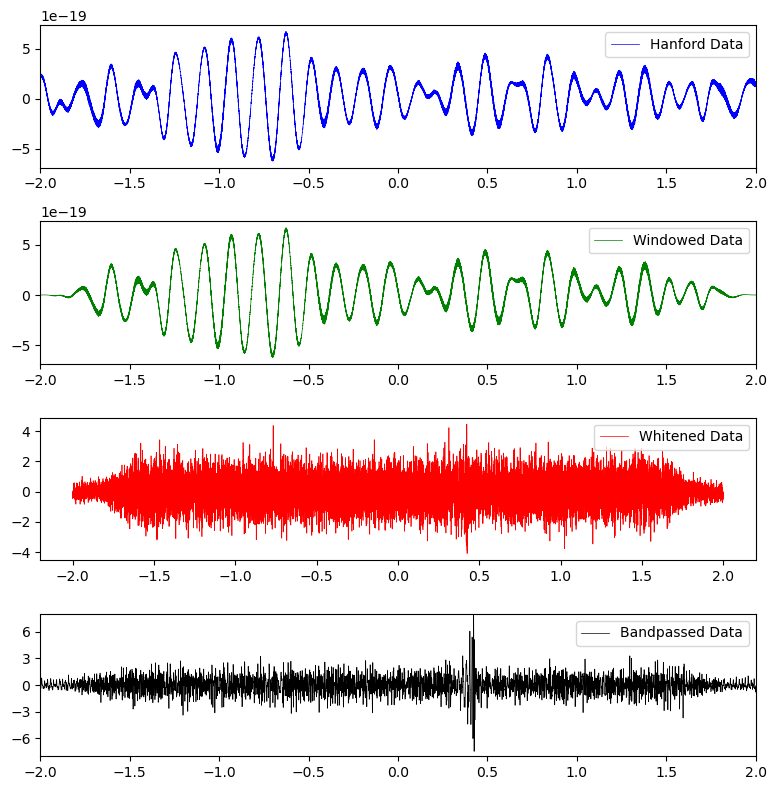

In [28]:
plot_strain_data('../../figs/fig1.pdf', fn_H1, fn_L1, 'GW150914')